In [1]:
import glob
import os
import pyart
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# suppress anoying iypthon warnings. Not ideal since we suppress also potentially relevant warnings
import warnings
warnings.filterwarnings('ignore')

/opt/anaconda3/envs/exts-ml2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Function to read original dataset
# data is stored as (nz, ny, nx), we return (nx, ny)
def read_nc(fname):
    sat_grid = pyart.io.read_grid(fname)
    for field_name in sat_grid.fields.keys():
        data = np.transpose(np.squeeze(sat_grid.fields[field_name]['data']))
    return data        

In [4]:
def compute_1d_hist(field, vmin, vmax, step):
    # get bins
    bin_edges = np.linspace(vmin-step/2., vmax+step/2., num=int((vmax-vmin)/step)+2)
    step_aux = bin_edges[1]-bin_edges[0]
    bin_centers = bin_edges[:-1]+step_aux/2.
    
    # data off limits is put at the bins in the extrems
    field[field < bin_centers[0]] = bin_centers[0]
    field[field > bin_centers[-1]] = bin_centers[-1]
    
    return np.histogram(field, bins=bin_edges)

In [5]:
def add_1d_hist(fbasepath, feature, vmin, vmax, step, target=None, target_filter=None):
    flist = glob.glob(fbasepath+'*/NETCDF/'+feature+'/'+'*.nc')
    if len(flist) == 0:
        return None
    flist.sort()
    
    hist_1d = None
    for fname in flist:
        # Get time step
        bfile = os.path.basename(fname)
        dt_str = bfile[0:14]
        print(dt_str, end="\r", flush=True)
        
        # get target file name    
        if target is not None:
            tflist = glob.glob(fbasepath+'*/NETCDF/'+target+'/'+dt_str+'*.nc')
            if len(tflist) == 0:
                continue
            
        # read data
        data = read_nc(fname).flatten()
        
        if target_filter is not None:
            tdata = read_nc(tflist[0]).flatten()
            tdata[tdata == 1] = 0
            tdata[tdata == 2] = 1
            data = data[tdata == target_filter]
            
        if hist_1d is None:
            hist_1d, bin_edges = compute_1d_hist(data, vmin, vmax, step)
        else:    
            hist_1d_aux, bin_edges = compute_1d_hist(data, vmin, vmax, step)
            hist_1d += hist_1d_aux
    
    return hist_1d, bin_edges        

In [6]:
def plot_1d_hist(hist_1d, bin_edges, feature, target_filter=None):
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    
    ax.bar(bin_edges[:-1], hist_1d, align='edge', width=bin_edges[1]-bin_edges[0])
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of pixels')
    if target_filter is None:
        ax.set_title('All data')
    elif target_filter == 0:
        ax.set_title('No POH90')
    else:
        ax.set_title('POH90')
        
    fig.tight_layout()

In [7]:
def save_1d_hist(hist_1d, bin_edges, feature, target_filter=None):
    if target_filter is None:
        lab = 'all_data'
    elif target_filter == 0:
        lab = 'No_POH90'
    else:
        lab = 'POH90'
    
    # Save data into a .npz file
    np.savez(
        '/data/ml_course/05_Capstone_project/hist_'+lab+'_'+feature+'.npz',
        hist=hist_1d, bin_edges=bin_edges)

# HRV_norm texture histogram

In [8]:
fbasepath = '/data/pyrad_products/MSG_ML/'
feature = 'HRV_norm_text'
target = 'POH90'

vmin = 0.
vmax = 100.
step = 1.

## All data

In [9]:
hist_1d, bin_edges = add_1d_hist(
    fbasepath, feature, vmin, vmax, step, target=None, target_filter=None)

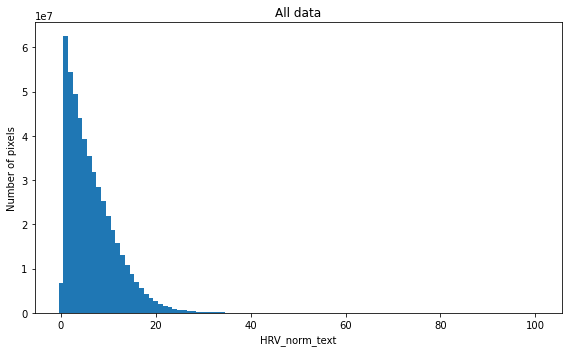

In [10]:
plot_1d_hist(hist_1d, bin_edges, feature, target_filter=None)

In [11]:
save_1d_hist(hist_1d, bin_edges, feature, target_filter=None)

## No hail

In [12]:
hist_1d, bin_edges = add_1d_hist(
    fbasepath, feature, vmin, vmax, step, target=target, target_filter=0)

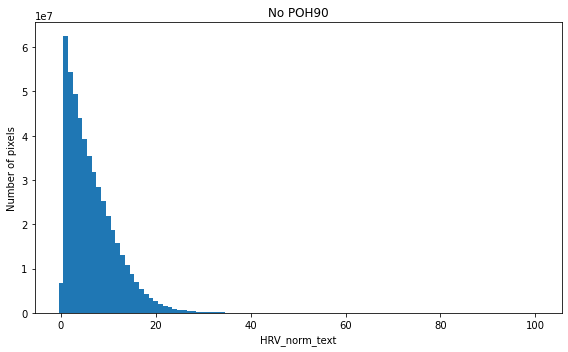

In [13]:
plot_1d_hist(hist_1d, bin_edges, feature, target_filter=0)

In [14]:
save_1d_hist(hist_1d, bin_edges, feature, target_filter=0)

## Hail

In [15]:
hist_1d, bin_edges = add_1d_hist(
    fbasepath, feature, vmin, vmax, step, target=target, target_filter=1)

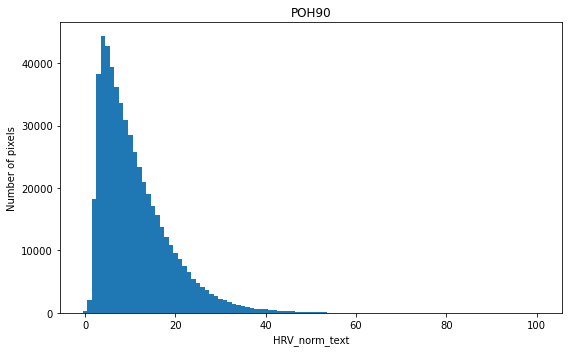

In [16]:
plot_1d_hist(hist_1d, bin_edges, feature, target_filter=1)

In [17]:
save_1d_hist(hist_1d, bin_edges, feature, target_filter=1)

# IR texture histogram

In [18]:
fbasepath = '/data/pyrad_products/MSG_ML/'
feature = 'IR_108_text'
target = 'POH90'

vmin = 0.
vmax = 40.
step = 1.

## All data

In [19]:
hist_1d, bin_edges = add_1d_hist(
    fbasepath, feature, vmin, vmax, step, target=None, target_filter=None)

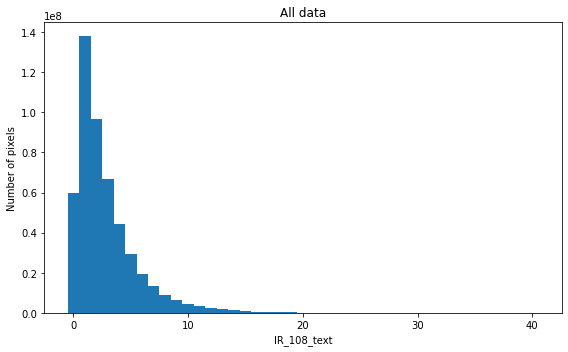

In [20]:
plot_1d_hist(hist_1d, bin_edges, feature, target_filter=None)

In [21]:
save_1d_hist(hist_1d, bin_edges, feature, target_filter=None)

## No hail

In [22]:
hist_1d, bin_edges = add_1d_hist(
    fbasepath, feature, vmin, vmax, step, target=target, target_filter=0)

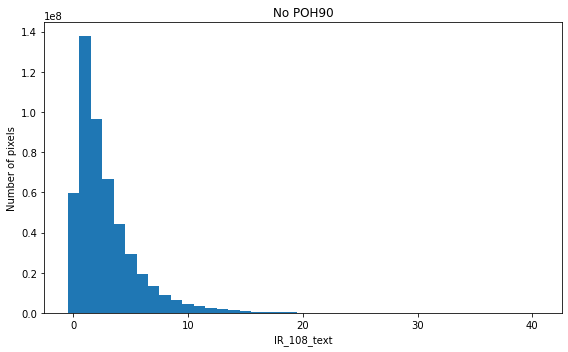

In [23]:
plot_1d_hist(hist_1d, bin_edges, feature, target_filter=0)

In [24]:
save_1d_hist(hist_1d, bin_edges, feature, target_filter=0)

## Hail

In [25]:
hist_1d, bin_edges = add_1d_hist(
    fbasepath, feature, vmin, vmax, step, target=target, target_filter=1)

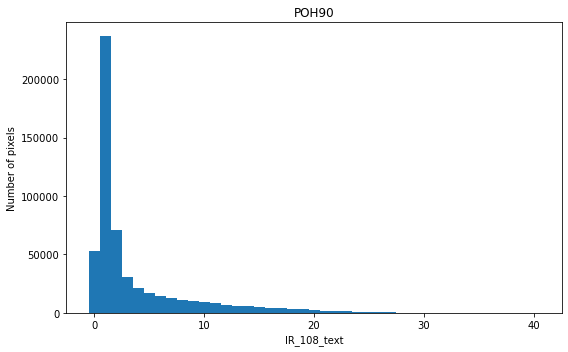

In [26]:
plot_1d_hist(hist_1d, bin_edges, feature, target_filter=1)

In [27]:
save_1d_hist(hist_1d, bin_edges, feature, target_filter=1)

# Channel differences histogram

In [28]:
fbasepath = '/data/pyrad_products/MSG_ML/'
feature = 'WV_062-IR_108_text'
target = 'POH90'

vmin = 0.
vmax = 30.
step = 1.

## All data

In [29]:
hist_1d, bin_edges = add_1d_hist(
    fbasepath, feature, vmin, vmax, step, target=None, target_filter=None)

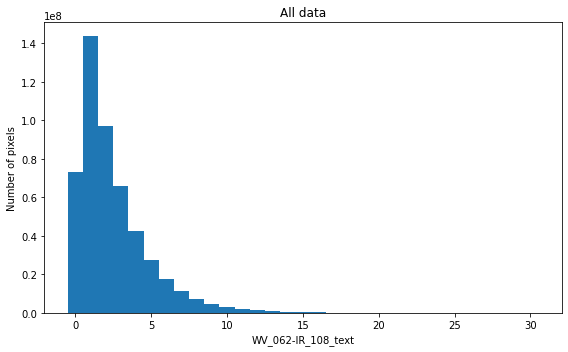

In [30]:
plot_1d_hist(hist_1d, bin_edges, feature, target_filter=None)

In [31]:
save_1d_hist(hist_1d, bin_edges, feature, target_filter=None)

## No hail

In [32]:
hist_1d, bin_edges = add_1d_hist(
    fbasepath, feature, vmin, vmax, step, target=target, target_filter=0)

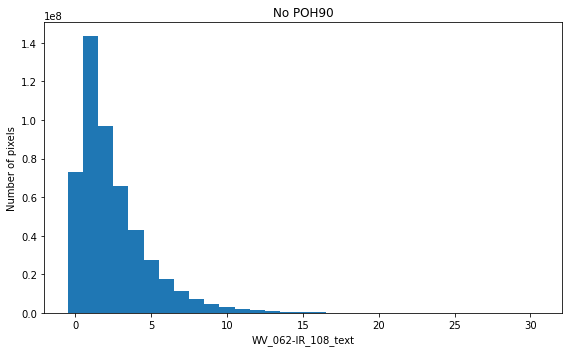

In [33]:
plot_1d_hist(hist_1d, bin_edges, feature, target_filter=0)

In [34]:
save_1d_hist(hist_1d, bin_edges, feature, target_filter=0)

## Hail

In [35]:
hist_1d, bin_edges = add_1d_hist(
    fbasepath, feature, vmin, vmax, step, target=target, target_filter=1)

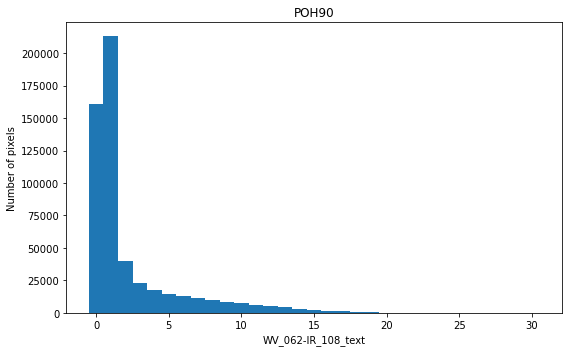

In [36]:
plot_1d_hist(hist_1d, bin_edges, feature, target_filter=1)

In [37]:
save_1d_hist(hist_1d, bin_edges, feature, target_filter=1)